## 7.5 부스팅

- 약한 학습기 여러 개 연결해 강한 학습기를 만드는 앙상블 방법
- 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것
- Ex. 에이다부스트, 그레이디언트 부스팅

### 7.5.1 에이다부스트

- 이전 예측기를 보완하는 새로운 예측기를 만드는 방법, 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것.
- 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됨.
- 에이다부스트 분류기를 만들 때 먼저 알고리즘이 기반이 되는 첫 번째 분류기를 훈련 세트에서 훈련시키고 예측을 만ㄷ름.
- 그 다음에 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임.
- 두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만듦.
- 그 다음에 가중치를 업데이트 하는 식으로 계속

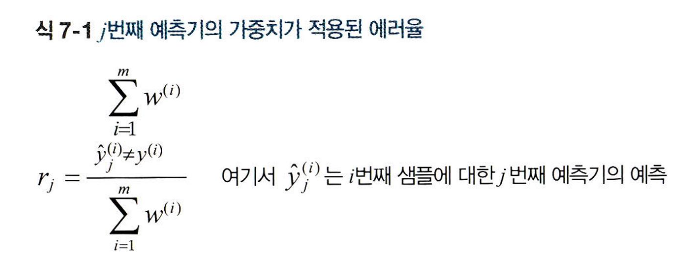

- 각 샘플의 가중치 𝒲(i)는 초기에 1/m로 초기화됨.
- 첫 번째 예측기가 학습되고, 가중치가 적용된 에러율 𝑟(i)이 훈련 세트에 대해 계산됨.

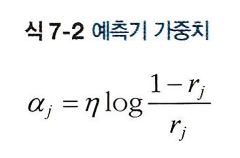

- 예측기의 가중치 𝛼(j)를 사용해 계산
- n는 학습률 하이퍼파라미터(기본값 1)
- 예측기가 정확할수록 가중치가 더 높아짐

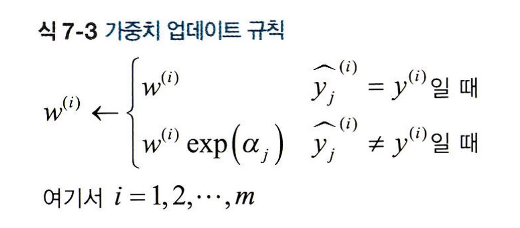

- 그 다음 에이다부스트 알고리즘을 사용해 샘플 가중치를 업데이트
- 잘못 분류된 샘플의 가중치 증가
- 그런 다음 모든 샘플의 가중치를 정규화

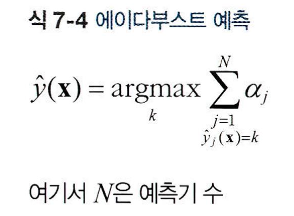

- 새 예측기가 업데이트된 가중치를 사용해 훈련되고 전체 과정이 반복
- 이 알고리즘은 지정된 예측기 수에 도달하거나 완벽한 예측기를 만들어지면 중지됨
- 예측할 때 에이다부스트는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치 𝛼(j)를 더해 예측 결과를 만듦.
- 가중치 합이 가장 큰 클래스가 예측 결과가 됨.

In [2]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME', learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅

- 앙승블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가
- 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킴

In [5]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [6]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [7]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [8]:
# y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(120))

In [14]:
# 조기종료 구현

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break

**확률적 그레이디언트 부스팅**
- subsample 매개변수 지원.
- 예를 들어, subsample=0.25 이면 각 트리는 무작위로 선택된 25% 훈련 샘플로 학습됨.

In [15]:
import xgboost

xgb_reg = xgboost.XGBRegressor(early_stopping_rounds=2)
xgb_reg.fit(X_train, y_train,
            eval_set = [(X_val, y_val)])
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.41995
[1]	validation_0-rmse:0.37961
[2]	validation_0-rmse:0.36467
[3]	validation_0-rmse:0.36263
[4]	validation_0-rmse:0.35953
[5]	validation_0-rmse:0.35971


## 7.6 스태킹

- 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델을 훈련시킴.
- 새 예측기는 각각 다른 값을 예측하고 마지막 예측기(블렌더 또는 메타 학습기)가 이 예측을 입력받아 최종 예측을 만듦.

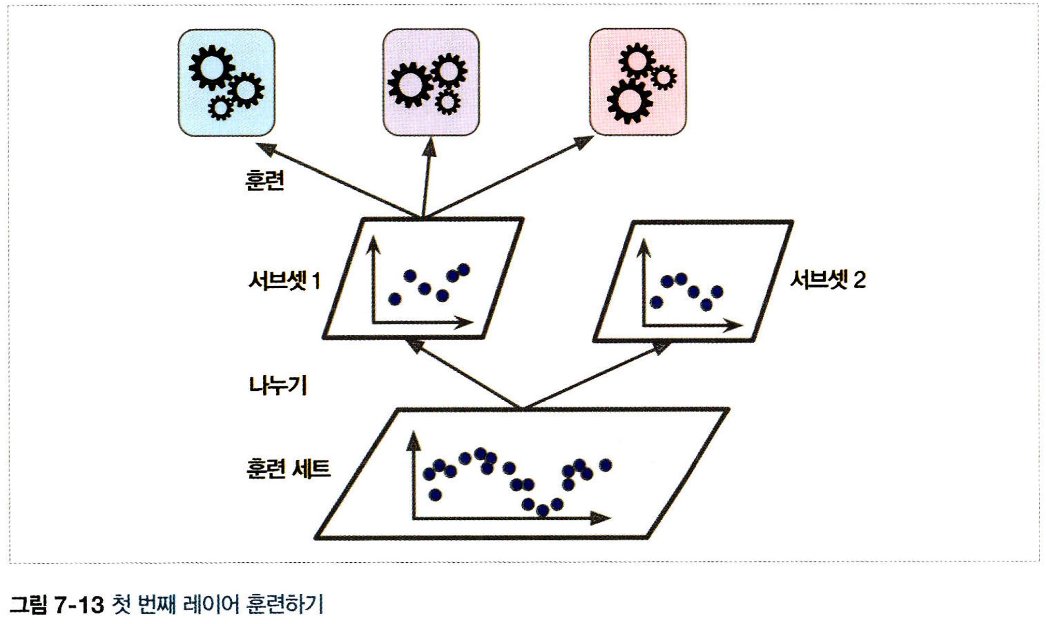

- 블렌더를 학습시키는 일반적인 방법은 홀드 아웃 세트를 사용
- 먼저 훈련 세트를 두 개의 서브셋으로 나눔
- 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용
- 그 다음 첫 번째 레이어의 예측기를 사용해 두 번째 (홀드 아웃) 세트에 대한 예측을 만듦
- 홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 있음. 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있음
- 블렌더가 새 훈련 세트로 훈련됨. 즉, 첫 번째 레이어의 예측을 가지고 타깃값을 예측하도록 학습